Characterize traffic patterns from the simulation:
What are the traffic hot spots? Is there any congestion?
What are the travel times? (How) do they vary throughout the day?
What are busy times? How well do they match the commute pattern from NHTS? <-  in data folder 
How do speeds vary spatially and temporally?
What are the most popular roads?
Can you draw conclusions about the simulation setup from the output?


Data to use:
- transims (agents)
- Link volumes
- time series plot matplotlib ?
- plot NHTS in folder

In [201]:
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import json
import numpy as np
from zipfile import ZipFile
import glob
import zipfile
from sklearn.neighbors import BallTree
import numpy as np
from shapely.geometry import LineString
import seaborn as sns

In [134]:
building_map = gpd.read_file("data/building_data/Building_Footprints/ChicagoLoop.geojson")
building_map=building_map.to_crs(epsg=26916)

In [169]:
# Link Volumes
os.chdir('/Users/elizabeth/Documents/smc-cuda-intersect/data/emissions_data/Traffic_Volumes/Link_Volumes/') #set folder as wd
link_vols= glob.glob('*.csv')
li = []
link_vols.sort()
for filename in link_vols:
    df = pd.read_csv(filename, index_col=None, header=0)
    f=(filename.split('_')[1])
    df['hour']=int(f.split('.csv')[0])
    df['day'] = filename
    df['day_of_week'] = filename.split('_')[0]
    li.append(df)
link_volumes = pd.concat(li, axis=0,ignore_index=True)
links = gpd.read_file("/Users/elizabeth/Documents/smc-cuda-intersect/data/road_network/RoadNetwork.geojson")
links = links.rename(columns={'LINKID': 'linkID'})
links=links.to_crs(epsg=26916)
links['linkID']=links['linkID'].astype(int)

link_volumes = link_volumes.merge(links,left_on='linkID',right_on='linkID')
os.chdir('/Users/elizabeth/Documents/smc-cuda-intersect/') #restore wd
link_volumes_gpd=gpd.GeoDataFrame(link_volumes, geometry=link_volumes['geometry'])



### The "link-hours" with the 100 highest volumes all occurred between 7 and 9am, and primarily on road types A40 and A30 (city streets and state highways, respectively). These 100 highest "emission-hour links" throughout the emissions-volume model outputs also occur on only 14 individual links. These links are grouped on the west side of the river, and one of the downtown sections on the eastern side of the network. These links are also closest to the buildings that were assigned the highest number of occupants in question 1, suggesting that high occupancy buildings are near high-emission and highly-traveled road links.

In [228]:
df_top100

,linkID,countyID,zoneID,roadTypeID,linkLength,linkVolume,linkAvgSpeed,linkDescription,linkAvgGrade,hour,day,day_of_week,FROM,TO,FCC,SPEED,MILES,LANES,DIRECT,geometry
13270,214,17031,0,5,0.058856,1254,2.910259,Urban Unrestricted,0,8,Thursday_8.csv,Thursday,245,246,A40,None,None,None,0,"LINESTRING (446801.718 4636856.151, 446735.430..."
13534,216,17031,0,5,0.034615,1245,12.569568,Urban Unrestricted,0,8,Tuesday_8.csv,Tuesday,247,248,A40,None,None,None,0,"LINESTRING (446679.664 4636854.488, 446556.750..."
13294,214,17031,0,5,0.058856,1219,3.671635,Urban Unrestricted,0,8,Tuesday_8.csv,Tuesday,245,246,A40,None,None,None,0,"LINESTRING (446801.718 4636856.151, 446735.430..."
13222,214,17031,0,5,0.058856,1204,2.779918,Urban Unrestricted,0,8,Friday_8.csv,Friday,245,246,A40,None,None,None,0,"LINESTRING (446801.718 4636856.151, 446735.430..."
13558,216,17031,0,5,0.034615,1199,11.315209,Urban Unrestricted,0,8,Wednesday_8.csv,Wednesday,247,248,A40,None,None,None,0,"LINESTRING (446679.664 4636854.488, 446556.750..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13607,217,17031,0,5,0.076290,798,18.530714,Urban Unrestricted,0,9,Monday_9.csv,Monday,249,148,A30,None,None,None,0,"LINESTRING (447905.973 4637141.869, 447770.447..."
13678,217,17031,0,5,0.076290,794,20.564510,Urban Unrestricted,0,8,Wednesday_8.csv,Wednesday,249,148,A30,None,None,None,0,"LINESTRING (447905.973 4637141.869, 447770.447..."
137061,2517,17031,0,5,0.004660,789,18.657503,Off-Network,0,7,Thursday_7.csv,Thursday,540,-173,A00,None,None,None,0,"LINESTRING (446671.525 4637286.702, 446662.393..."
13654,217,17031,0,5,0.076290,785,19.721449,Urban Unrestricted,0,8,Tuesday_8.csv,Tuesday,249,148,A30,None,None,None,0,"LINESTRING (447905.973 4637141.869, 447770.447..."


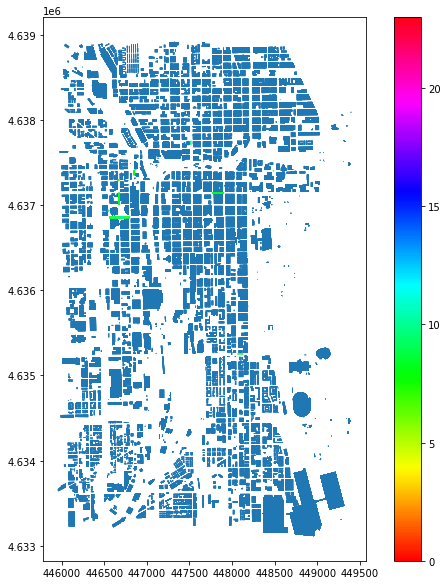

In [225]:
df_top100=link_volumes_gpd.sort_values(by='linkVolume',ascending=False).head(100)
fig,ax=plt.subplots(figsize=(10,10))
df_top100.plot(ax=ax, column='hour',cmap='hsv',vmin=0, vmax=23)
building_map.plot(ax=ax)
sm = plt.cm.ScalarMappable(cmap='hsv', norm=plt.Normalize(vmin=0, vmax=23))
fig.colorbar(sm,ax=ax)

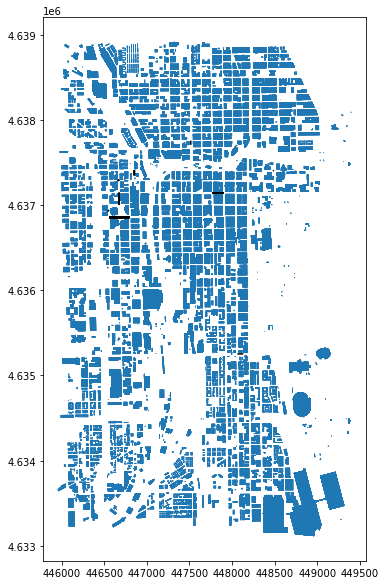

In [218]:
fig,ax=plt.subplots(figsize=(10,10))
array=[214,215,216,217,807,877,980,981,982,983,984,2399,2517,2536]
df.loc[df['linkID'].isin(array)].plot(ax=ax,color='black')
building_map.plot(ax=ax)

When absolute link speed is low, link speed increases with increasing volume on links of average length. On links that are very long or very short, no clear trend is visible with the top 100 link-emissions subset.


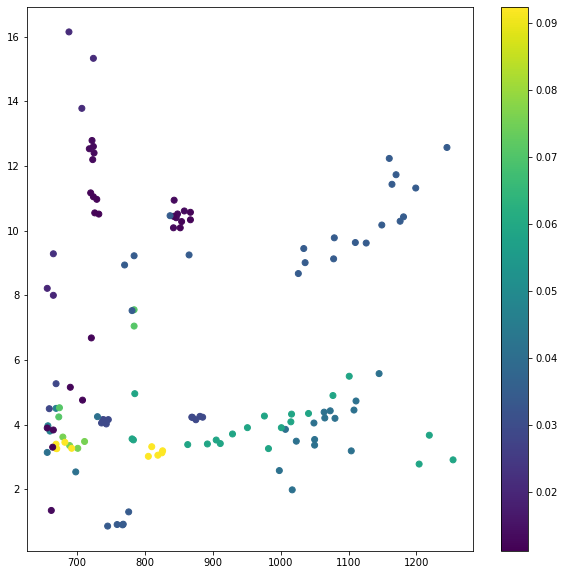

In [241]:
fig,ax=plt.subplots(figsize=(10,10))
plt.scatter(df_top200_a4050['linkVolume'],df_top200_a4050['linkAvgSpeed'],c=df_top200_a4050['linkLength'])
plt.colorbar()

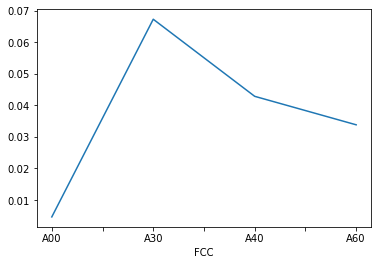

In [250]:
df_top100.groupby('FCC').mean()['linkLength'].plot()

<BarContainer object of 100 artists>

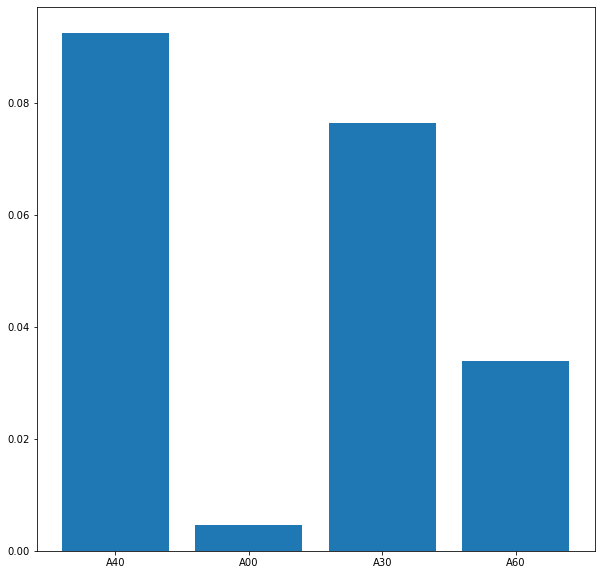

In [242]:
fig,ax=plt.subplots(figsize=(10,10))
ax.bar(df_top100['FCC'],df_top100['linkLength'])

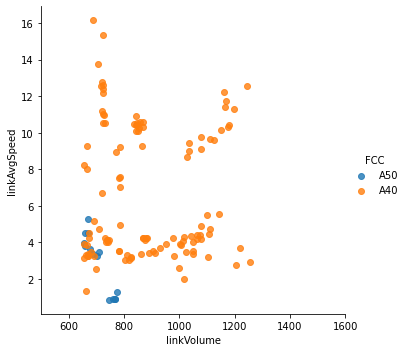

In [240]:
df_a50=df_top200[df_top200['FCC']=='A50']
df_a40=df_top200[df_top200['FCC']=='A40']
df_top200_a4050=[df_a50, df_a40]
df_top200_a4050=pd.concat(df_top200_a4050)
a_plot=sns.lmplot( x="linkVolume", y="linkAvgSpeed", data=df_top200_a4050, fit_reg=False, hue='FCC', legend_out=True)
a_plot.set(xlim=(500, 1600))
plt.show()

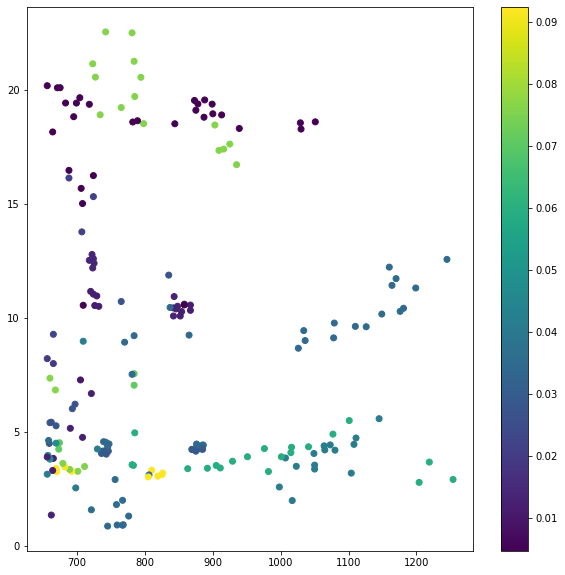

In [235]:
df_top200=link_volumes_gpd.sort_values(by='linkVolume',ascending=False).head(200)

fig,ax=plt.subplots(figsize=(10,10))
plt.scatter(df_top200['linkVolume'],df_top200['linkAvgSpeed'],c=df_top200['linkLength'])
plt.colorbar()

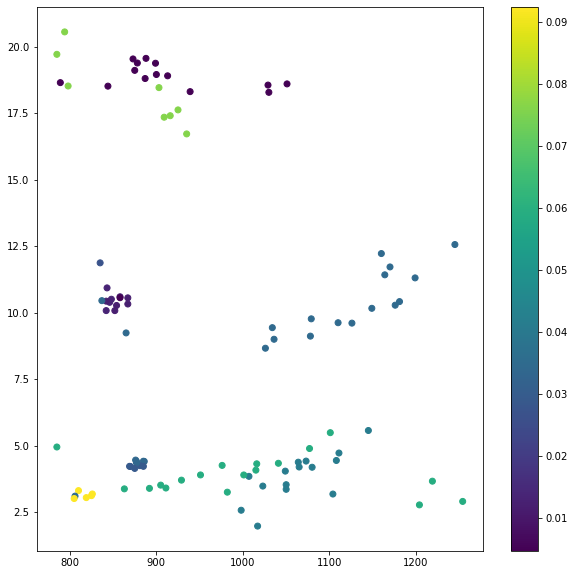

In [233]:
fig,ax=plt.subplots(figsize=(10,10))
plt.scatter(df_top100['linkVolume'],df_top100['linkAvgSpeed'],c=df_top100['linkLength'])
plt.colorbar()

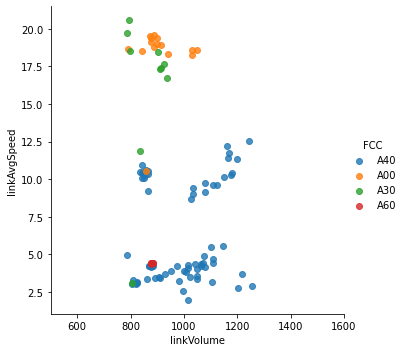

In [219]:
a_plot=sns.lmplot( x="linkVolume", y="linkAvgSpeed", data=df, fit_reg=False, hue='FCC', legend_out=True)
a_plot.set(xlim=(500, 1600))
plt.show()

In [66]:
#commute schedule
home2work=pd.read_csv('data/vehicle_data/Commute Schedule/nhts_home2work.csv')
home2work

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.001368,0.001368,0.001368,0.001368,0.001368,0.000000,0.000000
4,0.020520,0.020520,0.020520,0.020520,0.020520,0.033333,0.033333
5,0.062927,0.062927,0.062927,0.062927,0.062927,0.066667,0.066667
6,0.158687,0.158687,0.158687,0.158687,0.158687,0.133333,0.133333
7,0.238030,0.238030,0.238030,0.238030,0.238030,0.083333,0.083333
8,0.142271,0.142271,0.142271,0.142271,0.142271,0.116667,0.116667
9,0.065663,0.065663,0.065663,0.065663,0.065663,0.033333,0.033333


In [222]:
link_schedule=link_volumes_gpd.groupby(['day_of_week','hour'])['linkVolume'].mean()
days=['Monday','Tuesday','Wednesday','Thursday','Friday']
li=[]
for day in days:
    df=link_schedule[day]
    li.append(df)

In [223]:
df=pd.DataFrame(li)
df.reset_index()
df['day']=days
df2=df.transpose()
df2.columns=days
df3=df2[:-1]
df2=df.transpose()
df2.columns=days
df3=df2[:-1]

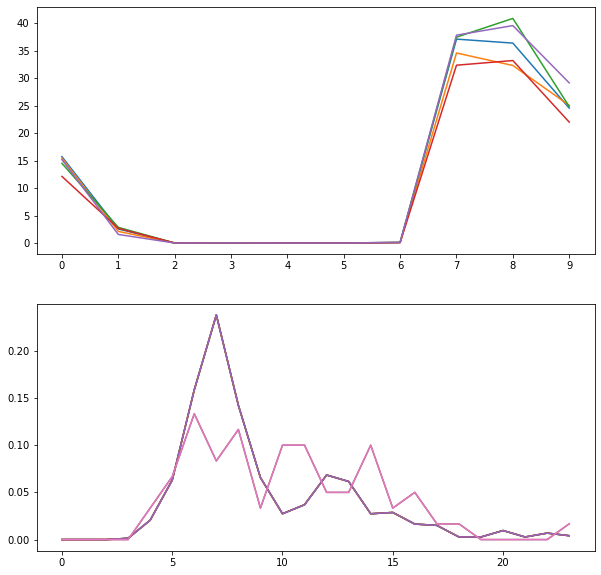

In [98]:
fig,(ax1,ax2)=plt.subplots(2,figsize=(10,10))
ax1.plot(df3.iloc[0:10])
ax2.plot(home2work)

## how to get fractional plot for df3?

In [90]:
df3.loc['Total']= df3.sum()
total=df3.loc['Total']
df4=pd.DataFrame(np.zeros((9,4)))
#for i in np.arange(0,9,1):
#    for j in np.arange(0,4,1):
#        df4.iloc[i,j]=df3.iloc[i,j]/df3.loc['Total']

ValueError: Incompatible indexer with Series